## Building a Simple Decision Tree

In this tutorial we'll build a machine learning model that classifies molecules as soluble or insoluble.  After building the model, we'll visualize the results.  

### Software Installation
One of the Python libraries [dtreeviz](https://github.com/parrt/dtreeviz) that we are going to install requires the installation of a program called [graphviz](https://graphviz.org/).  We can use [apt-get](https://help.ubuntu.com/community/AptGet/Howto) to install graphviz. 

In [1]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-1

Install the necessary Python libraries

In [6]:
!pip install dtreeviz rdkit-pypi PyTDC

     |████████████████████████████████| 88 kB 3.3 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.5-py3-none-any.whl size=119793 sha256=7cd4395cdbe8b1ebe80f51b1efe13e2600ede2edfdcf47db7cce007777cceb22
  Stored in directory: /root/.cache/pip/wheels/69/58/63/c310ca1fb3eb9d640d1c8e9acccc8c95039f2e26d4c63ffcae
Successfully built PyTDC


### Setup
Import the necessary Python libraries

In [3]:
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # descision trees 
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats
from tdc.single_pred import ADME

We want to have progress bars for operations we perfrom on the Pandas dataframe.  In order to do this we neeed to use the function [tqdm.pandas](https://datascientyst.com/progress-bars-pandas-python-tqdm/).

In [4]:
tqdm.pandas()

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

In [5]:
def calc_descriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

### Reading the Input Data
Read data from ["ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure"](https://pubs.acs.org/doi/10.1021/ci034243x) from the [Therapeutic Data Commons](https://tdcommons.ai/)

In [6]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████| 853k/853k [00:00<00:00, 2.35MiB/s]
Loading...
Done!


Let's take a look at the input data, which has three columns
- Drug_ID - the molecule name
- Drug - the SMILES
- Y - the log of the aqueous solubility in uM

In [7]:
sol_df

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


I don't like the names of the columns, let's rename them. 

In [8]:
sol_df.columns = ["Name","SMILES","LogS"]
sol_df

,Name,SMILES,LogS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


Now let's reorder the columns.

In [9]:
sol_df = sol_df[['SMILES','Name','LogS']]
sol_df

,SMILES,Name,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065
...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000


Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM

In [10]:
sol_df['IsSol'] = sol_df.LogS > math.log10(200 * 1e-6)

Plot solubility as a sanity check

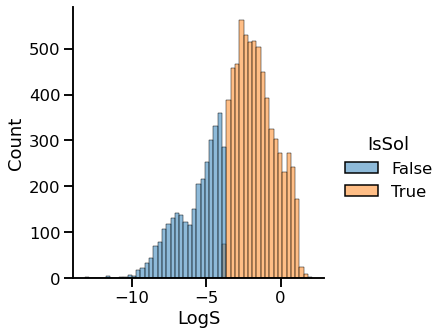

In [11]:
sns.set_context('talk') # Set the fonts the way I like them
sns.displot(x='LogS',hue="IsSol",data=sol_df)

Add the descriptors to the dataframe.  Note that all of the descriptors are going into one column called "desc".

In [12]:
sol_df['desc'] = sol_df.SMILES.progress_apply(calc_descriptors)

  3%|██▏                                                                            | 284/9982 [00:00<00:06, 1460.37it/s]RDKit WARNING: [23:17:03] WARNING: not removing hydrogen atom without neighbors
[23:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:03] WARNING: not removing hydrogen atom without neighbors
[23:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:03] WARNING: not removing hydrogen atom without neighbors
[23:17:03] WARNING: not removing hydrogen atom without neighbors
  6%|█████                                                                          | 641/9982 [00:00<00:05, 1670.28it/s]RDKit WARNING: [23:17:03] WARNING: not removing hydrogen atom without neighbors
[23:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:03] WARNING: not removing hydrogen atom without neighbors
[23:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:03] WARNING

 31%|████████████████████████                                                      | 3077/9982 [00:02<00:04, 1618.19it/s]RDKit WARNING: [23:17:05] WARNING: not removing hydrogen atom without neighbors
[23:17:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:05] WARNING: not removing hydrogen atom without neighbors
[23:17:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:05] WARNING: not removing hydrogen atom without neighbors
[23:17:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:05] WARNING: not removing hydrogen atom without neighbors
[23:17:05] WARNING: not removing hydrogen atom without neighbors
 32%|█████████████████████████▎                                                    | 3240/9982 [00:02<00:04, 1591.86it/s]RDKit WARNING: [23:17:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:17:05] WARNING: not removing hydrogen atom without neighbors
[23:17:05] WARNING

The function call in the cell above put all of the descriptors into a single column called **desc**.  We would like split the descriptors so that each is in its own column.

In [17]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.desc.to_list()

We no longer need the "desc" column, let's get rid of it. 

In [18]:
sol_df.drop("desc",axis=1,inplace=True)

Let's check the dataframe to make sure it's ok. 

In [19]:
sol_df

,SMILES,Name,LogS,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,True,392.510,3.95810,0.0,0.0,0.0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,True,169.183,2.40550,2.0,1.0,1.0
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,True,140.569,2.15250,1.0,0.0,1.0
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,False,756.226,8.11610,6.0,2.0,6.0
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,False,422.525,2.48540,2.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,True,264.369,2.61700,1.0,1.0,4.0
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,True,444.440,-0.21440,1.0,6.0,9.0
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,True,150.221,2.82402,1.0,1.0,1.0
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,False,454.611,5.09308,2.0,0.0,6.0


Split the data into training and test sets. 

In [20]:
train, test = train_test_split(sol_df)

Split the training and test sets into X and y variables. 

In [21]:
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

Create and train a classifier

In [22]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

Predict on the test set

In [23]:
pred = cls.predict(test_X)
auc, mcc, kappa = roc_auc_score(test_y, pred),matthews_corrcoef(test_y,pred),cohen_kappa_score(test_y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.82
Matthews Correlation Coefficient = 0.65
Cohen's Kappa = 0.65


Plot a confusion matrix to show the classifier performance

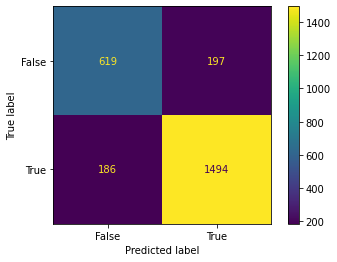

In [24]:
plot_confusion_matrix(cls,test_X,test_y)

Plot an ROC cure to show the classifier performance

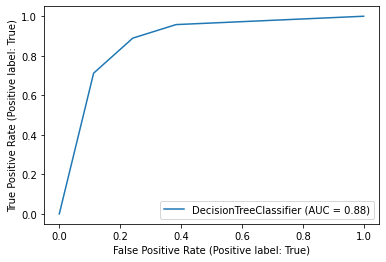

In [25]:
plot_roc_curve(cls,test_X,test_y)

Use the default view from SciKit Learn to plot the decision tree

[Text(0.5, 0.8333333333333334, 'LogP <= 2.946\ngini = 0.441\nsamples = 7486\nvalue = [2453, 5033]'),
 Text(0.25, 0.5, 'MW <= 268.316\ngini = 0.205\nsamples = 5120\nvalue = [594, 4526]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.138\nsamples = 3904\nvalue = [290, 3614]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.375\nsamples = 1216\nvalue = [304, 912]'),
 Text(0.75, 0.5, 'LogP <= 3.602\ngini = 0.337\nsamples = 2366\nvalue = [1859, 507]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.494\nsamples = 671\nvalue = [371, 300]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.214\nsamples = 1695\nvalue = [1488, 207]')]

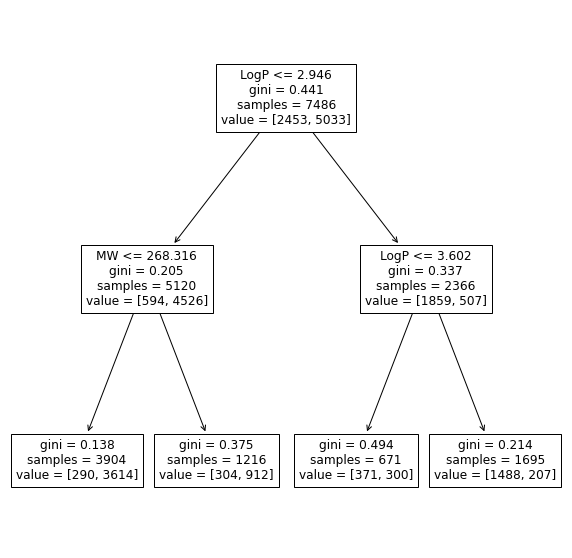

In [26]:
plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)

Use dtreeviz to plot the decision tree

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


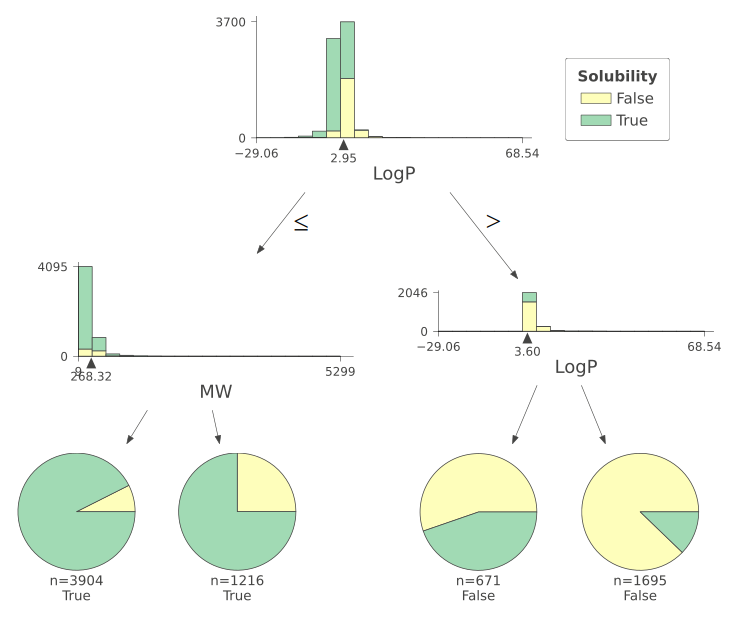

In [27]:
viz = dtreeviz(cls, train_X, train_y, feature_names = desc_cols, 
               target_name = "Solubility",class_names=["False","True"],scale=2)
viz

As a final check we're going to see if we can fit a model to incorrect data.  If we shuffle the y values, we shouldn't be able to get a good model. 

Shuffle the y-variable as a sanity check

In [28]:
sol_df['fake'] = sol_df.IsSol.sample(frac=1)

Split the dataframe into training a test sets. 

In [29]:
fake_train, fake_test = train_test_split(sol_df)

Split the training and test sets into X and y variables

In [30]:
fake_train_X = fake_train[desc_cols]
fake_train_y = fake_train.fake
fake_test_X = fake_test[desc_cols]
fake_test_y = fake_test.fake

Build a classifer

In [31]:
fake_cls = DecisionTreeClassifier(max_depth=2)
fake_cls.fit(fake_train_X,fake_train_y)

DecisionTreeClassifier(max_depth=2)

Generate the predictions

In [32]:
fake_pred = fake_cls.predict(fake_test_X)

Calculate the AUC score

In [33]:
roc_auc_score(fake_test_y,pred)

0.5147169833232684